![Banner](./img/AI_Special_Program_Banner.jpg)

# Combination of different learning algorithms - Ensemble Learning
---

In this section, we will look at **ensemble methods**, i.e. the combination of several learning algorithms into a single unit. This *ensemble* often has better predictive power than the individual algorithms that make it up. An ensemble is therefore literally *"more than the sum of its parts "*.

This notebook is based on chapter 7 of the book by [Sebastian Raschka](http://sebastianraschka.com). Apart from the general structure of the notebook, however, some significant changes have been made.

https://github.com/rasbt/python-machine-learning-book

In [1]:
from IPython.display import Image
import matplotlib.pyplot as plt
%matplotlib inline

## Table of contents
---

- [Learning with ensembles](#Learning-with-ensembles)
    - [General ensemble approach](#General-ensemble-approach)
    - [Illustration of ensemble error vs base error](#Illustration-of-ensemble-error-vs-base-error)
- [Implementation of a simple classifier by majority vote](#Implementation-of-a-simple-classifier-by-majority-vote)
  - [Combination of different classification algorithms by majority decision](#Combination-of-different-classification-algorithms-by-majority-decision)
    - [Pipelines](#Pipelines)
    - [Voting classifier](#Voting-classifier)
- [Evaluation and tuning of the ensemble classifier](#Evaluation-and-tuning-of-the-ensemble-classifier)
    - [Decision areas](#Decision-areas)
    - [Adaptation of the ensemble](#Adaptation-of-the-ensemble)
- [Bagging - An ensemble of classifiers by bootstrapping samples](#Bagging---An-ensemble-of-classifiers-by-bootstrapping-samples)
    - [Basic idea](#Basic-idea)
    - [Special case: Random-Forest](#Special-case:-Random-Forest)
    - [Example: Wine recognition](#Example:-Wine-recognition)
    - [Summary: Advantages of bagging](#Summary:-Advantages-of-bagging)
- [Utilization of weak learning methods through adaptive boosting](#Utilization-of-weak-learning-methods-through-adaptive-boosting)
    - [Adaboost](#Adaboost)
- [Learning outcomes](#Learning-outcomes)

# Learning with ensembles
---

**Reasoning**: Obtain several (expert) opinions and use the most frequently mentioned!

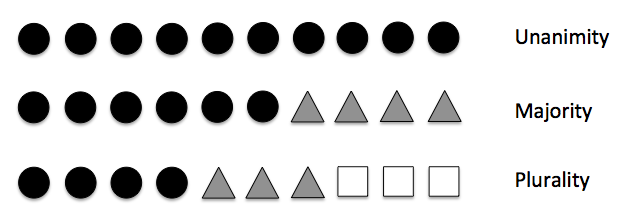

In [2]:
Image(filename='./img/07_01.png', width=500) 

Technically, there is a difference between *majority* (for binary classification) and *plurality* (for multiclass problems), but the commonly used term is *majority* for both binary and multiclass problems.

## General ensemble approach

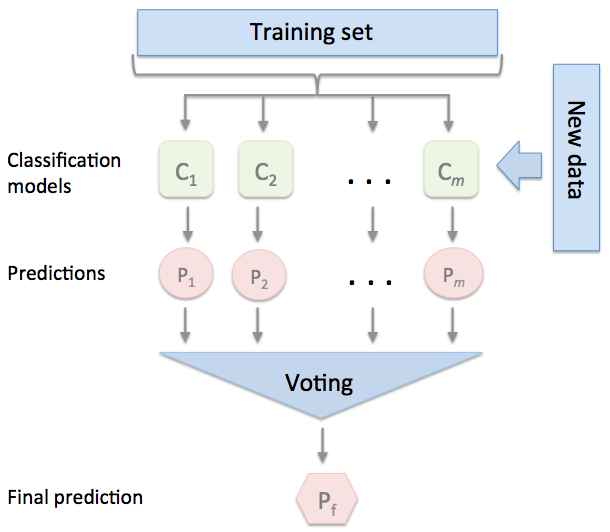

In [3]:
Image(filename='./img/07_02.png', width=500) 

## Illustration of ensemble error vs base error

We consider a *binary classification task* with the classes $0$ and $1$, with $m$ base classifiers $C_j\>,\ j=1,\dots,m$. Then the ensemble classifier $C_e$ would assign the class label $1$ to a sample $\mathbf{x}$ if at least half of the base classifiers assign the label $1$. We can first sum the class votes to obtain the number $y$ of votes for the class label $1$, i.e.
$$
y = \sum_{j=1}^m C_j(\mathbf{x})\>.
$$

Assuming that all base classifiers have the same *error rate* $\varepsilon$ but are *independent* and the error rates are *uncorrelated*, the *error probability* $\varepsilon_e$ of the ensemble classifier is
$$
\varepsilon_e = P(y\geq k) = \sum_k^m {m\choose k} \varepsilon^k(1-\varepsilon)^{m-k}
$$
with $k=\lceil{\frac m2}\rceil$.

Let's take a look at this using a small function.

In [4]:
from scipy.special import comb
import math

def ensemble_error(n_classifier, error):
    k_start = math.ceil(n_classifier / 2.0)
    probs = [comb(n_classifier, k) * error**k * 
               (1-error)**(n_classifier - k) 
             for k in range(k_start, n_classifier + 1)]
    return sum(probs)

In [5]:
ensemble_error(n_classifier=11, error=0.25)

0.03432750701904297

The error rate of the ensemble (0.034) is therefore significantly lower than the error rate of the individual classifiers (0.25). We can illustrate this relationship with a plot:

In [6]:
import numpy as np
error_range = np.arange(0.0, 1.01, 0.01)
n_classifier = 11
ens_errors = [ensemble_error(n_classifier=n_classifier, 
                             error=error) 
              for error in error_range]

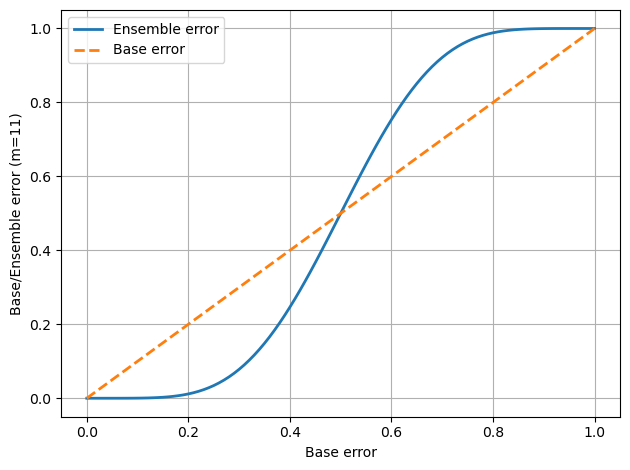

In [7]:
plt.plot(error_range, 
         ens_errors, 
         label='Ensemble error', 
         linewidth=2)

plt.plot(error_range, 
         error_range, 
         linestyle='--',
         label='Base error',
         linewidth=2)

plt.xlabel('Base error')
plt.ylabel('Base/Ensemble error (m='+str(n_classifier)+')')
plt.legend(loc='upper left')
plt.grid()
plt.tight_layout()
# plt.savefig('./figures/ensemble_err.png', dpi=300)
plt.show()

We find that the error of an ensemble is significantly lower than that of the individual base classifiers - at least as long as they are better than chance ($\varepsilon < 0.5$).

# Implementation of a simple classifier by majority vote
---

To make a majority decision, we collect the individual votes and then find out how many times each class label was voted for. We could do this with *weights* (which would mean that we trust some experts more than others). This would be called **hard voting** because we don't take *class probabilities* into account. If we did, it would be called **soft voting**. In practice, the `numpy` function `bincount` is used.

See also examples for `np.bincount` on [GeeksforGeeks](https://www.geeksforgeeks.org/numpy-bincount-python/) or the [SciPy documentation](https://numpy.org/doc/stable/reference/generated/numpy.bincount.html).

**Example 1**: Counting how often a certain label was assigned (*hard vote*)

In [8]:
import numpy as np
bc = np.bincount([0,0,1])
bc

array([2, 1])

**Example 2**: Counting how many times a particular label has been assigned, taking into account the *confidence* we have in each classifier (still *hard voting*)

In [9]:
bc = np.bincount([0, 0, 1], 
                      weights=[0.2, 0.2, 0.6])
bc

array([0.4, 0.6])

With `np.argmax` we can find the array *index* with the highest value, which here corresponds to the *class name*.

In [10]:
np.argmax(bc)

1

In [11]:
np.argmin(bc)

0

**Example 3**: Use of *class probabilities* as well as *weights* (*soft voting*)

In [12]:
ex = np.array([[0.9, 0.1],
               [0.8, 0.2],
               [0.4, 0.6]])

p = np.average(ex, 
               axis=0, 
               weights=[0.2, 0.2, 0.6])
p

array([0.58, 0.42])

In [13]:
np.argmax(p)

0

## Combination of different classification algorithms by majority decision

To illustrate this, we again use part of the *Iris dataset* so that the classification problem becomes binary again.

In [14]:
from sklearn import datasets
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

iris = datasets.load_iris()
X, y = iris.data[50:, [1, 2]], iris.target[50:]
le = LabelEncoder()
y = le.fit_transform(y)

X_train, X_test, y_train, y_test =\
       train_test_split(X, y, 
                        test_size=0.5, 
                        random_state=1)

### Pipelines

We are familiar with the use of pipelines from the *evaluation* event. In the following, we look at three different classifiers and evaluate their performance with a cross-validation using the AUC score.

In [15]:
from sklearn.model_selection import cross_val_score 
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.pipeline import Pipeline
import numpy as np

clf_lr = LogisticRegression(penalty='l2',
                            solver='lbfgs',
                            C=0.1, 
                            random_state=0)

clf_dt = DecisionTreeClassifier(max_depth=1, 
                                criterion='entropy', 
                                random_state=0)

clf_knn = KNeighborsClassifier(n_neighbors=1, 
                               p=2, 
                               metric='minkowski')

pipe_lr = Pipeline([['sc', StandardScaler()],
                   ['clf', clf_lr]])
pipe_knn = Pipeline([['sc', StandardScaler()],
                    ['clf', clf_knn]])

clf_labels = ['Logistic Regression', 'Decision Tree', 'KNN']

print('10-fold cross validation:\n')
for clf, label in zip([pipe_lr, clf_dt, pipe_knn], clf_labels):
    scores = cross_val_score(estimator=clf, 
                             X=X_train, 
                             y=y_train, 
                             cv=10, 
                             scoring='roc_auc') 
    print("ROC AUC: %0.2f (+/- %0.2f) [%s]" 
               % (scores.mean(), scores.std(), label))

10-fold cross validation:

ROC AUC: 0.98 (+/- 0.05) [Logistic Regression]
ROC AUC: 0.93 (+/- 0.11) [Decision Tree]
ROC AUC: 0.93 (+/- 0.15) [KNN]


### Voting classifier

To create a voting ensemble from the three classifiers using `sklearn`, we can use the function [VotingClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html):

In [16]:
# Majority Rule (soft) voting (no ROC/AUC available for hard voting)
from sklearn.ensemble import VotingClassifier
clf_mv = VotingClassifier(estimators=[('lr',pipe_lr), ('dt',clf_dt), ('knn',pipe_knn)], voting='soft')

# note: proba is not available with hard voting, so in that case we would have to settle for accuracy instead of roc_auc

clf_labels += ['Majority Voting']
all_clf = [pipe_lr, clf_dt, pipe_knn, clf_mv]

for clf, label in zip(all_clf, clf_labels):
    scores = cross_val_score(estimator=clf, 
                             X=X_train, 
                             y=y_train, 
                             cv=10, 
                             scoring='roc_auc') # accuracy would be possible with hard voting
    print("ROC AUC: %0.2f (+/- %0.2f) [%s]" 
               % (scores.mean(), scores.std(), label))

ROC AUC: 0.98 (+/- 0.05) [Logistic Regression]
ROC AUC: 0.93 (+/- 0.11) [Decision Tree]
ROC AUC: 0.93 (+/- 0.15) [KNN]
ROC AUC: 0.98 (+/- 0.05) [Majority Voting]


The cross-validation thus shows very high values for all estimators, but the majority voter in particular performs almost ideally. However, we have not yet tested the models on unseen data, i.e. we have not yet evaluated them on the test data. In this context, note in particular the 93% score of the KNN.

# Evaluation and tuning of the ensemble classifier
---

We will now plot the ROC-AUC curve using our test data to see how well our estimators generalize.

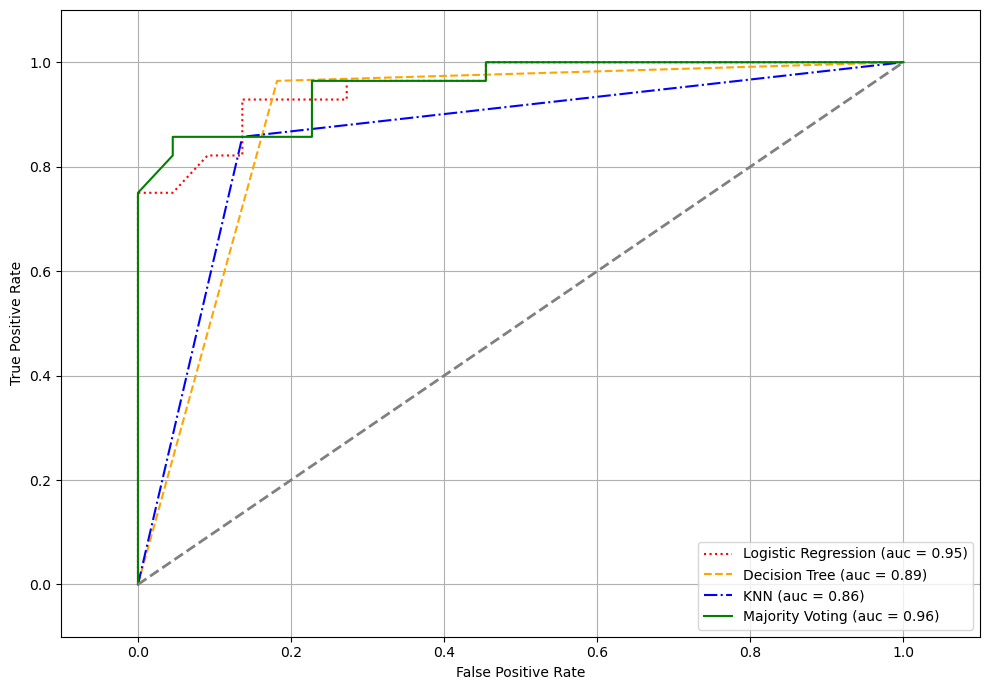

In [17]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

plt.figure(figsize=(10,7))
colors = ['red', 'orange', 'blue', 'green']
linestyles = [':', '--', '-.', '-']
for clf, label, clr, ls \
        in zip(all_clf, 
               clf_labels, colors, linestyles):

    # assuming the label of the positive class is 1
    y_pred = clf.fit(X_train, 
                     y_train).predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_true=y_test, 
                                     y_score=y_pred)
    roc_auc = auc(x=fpr, y=tpr)
    plt.plot(fpr, tpr, 
             color=clr, 
             linestyle=ls, 
             label='%s (auc = %0.2f)' % (label, roc_auc))

plt.plot([0, 1], [0, 1], 
         linestyle='--', 
         color='gray', 
         linewidth=2,)

plt.legend(loc='lower right')
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.tight_layout()
# plt.savefig('./figures/roc.png', dpi=300)
plt.show()

Logistic regression and majority voting perform as well on the test data as on the training data (no or negligible difference), while DT and especially KNN perform significantly worse, indicating overfitting (at least for KNN). Majority voting can mitigate this effect.

### Decision areas

Since we have selected only two features for the classification examples, it would be
interesting to see what the decision area of the ensemble classifier actually looks like. Although it is not necessary to standardize the training data before model fitting
(this is done by the pipeline for LR and KNN), we will standardize the training data anyway so that the decision regions of the decision tree are on the same scale for visual purposes.

In [18]:
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)

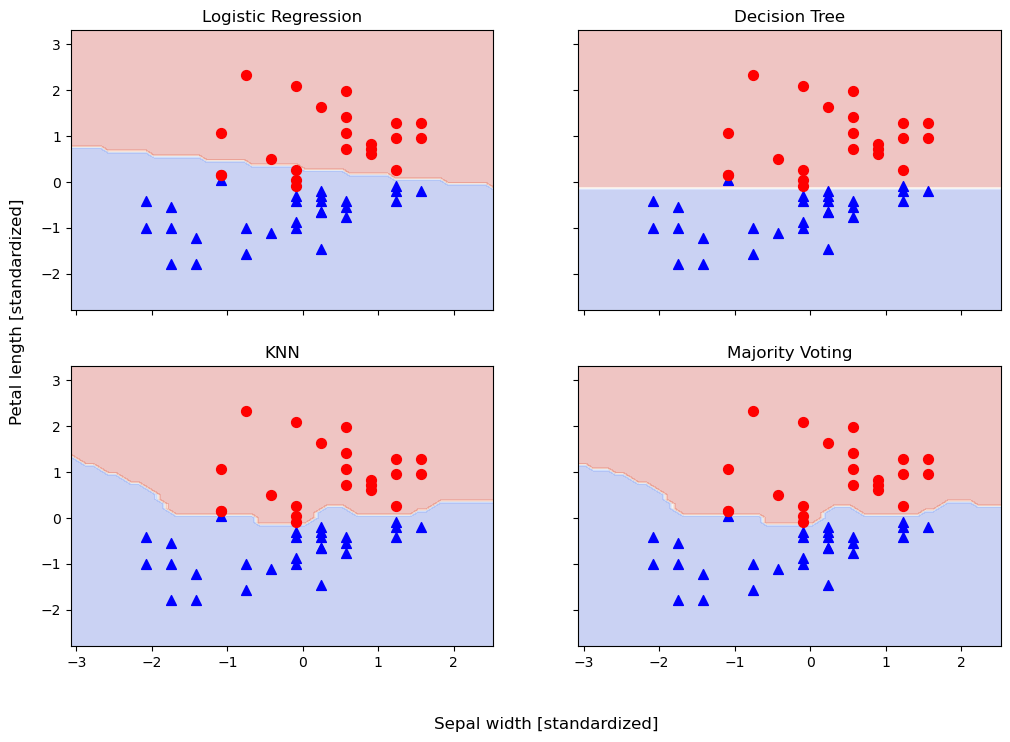

In [19]:
from itertools import product

# now the data is scaled anyway and we do not need the pipelines anymore
clf_mv = VotingClassifier(estimators=[('lr',clf_lr), ('dt',clf_dt), ('knn',clf_knn)], voting='soft')
all_clf = [clf_lr, clf_dt, clf_knn, clf_mv]

x_min = X_train_std[:, 0].min() - 1
x_max = X_train_std[:, 0].max() + 1
y_min = X_train_std[:, 1].min() - 1
y_max = X_train_std[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(nrows=2, ncols=2, 
                        sharex='col', 
                        sharey='row', 
                        figsize=(12, 8))

for idx, clf, tt in zip(product([0, 1], [0, 1]),
                        all_clf, clf_labels):
    clf.fit(X_train_std, y_train)
    
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    axarr[idx[0], idx[1]].contourf(xx, yy, Z, cmap='coolwarm', alpha=0.3)
    
    axarr[idx[0], idx[1]].scatter(X_train_std[y_train==0, 0], 
                                  X_train_std[y_train==0, 1], 
                                  c='blue', 
                                  marker='^',
                                  s=50)
    
    axarr[idx[0], idx[1]].scatter(X_train_std[y_train==1, 0], 
                                  X_train_std[y_train==1, 1], 
                                  c='red', 
                                  marker='o',
                                  s=50)
    
    axarr[idx[0], idx[1]].set_title(tt)

plt.text(-3.5, -4.5, 
         s='Sepal width [standardized]', 
         ha='center', va='center', fontsize=12)
plt.text(-10.5, 4.5, 
         s='Petal length [standardized]', 
         ha='center', va='center', 
         fontsize=12, rotation=90)

# plt.tight_layout()
# plt.savefig('./figures/voting_panel', bbox_inches='tight', dpi=300)
plt.show()

Although we would expect this, it is no less interesting that the decision domains of the ensemble classifier
seem to be a hybrid of the decision domains of the individual classifiers. In fact
the decision boundary of the majority decision looks very similar to the decision boundary of the
KNN classifier. However, it seems that the small difference that can be seen on the right
side for the training data makes the difference in the generalization.

### Adaptation of the ensemble

We first check which parameters we can adjust in the ensemble.

In [20]:
clf_mv.get_params()

{'estimators': [('lr', LogisticRegression(C=0.1, random_state=0)),
  ('dt',
   DecisionTreeClassifier(criterion='entropy', max_depth=1, random_state=0)),
  ('knn', KNeighborsClassifier(n_neighbors=1))],
 'flatten_transform': True,
 'n_jobs': None,
 'verbose': False,
 'voting': 'soft',
 'weights': None,
 'lr': LogisticRegression(C=0.1, random_state=0),
 'dt': DecisionTreeClassifier(criterion='entropy', max_depth=1, random_state=0),
 'knn': KNeighborsClassifier(n_neighbors=1),
 'lr__C': 0.1,
 'lr__class_weight': None,
 'lr__dual': False,
 'lr__fit_intercept': True,
 'lr__intercept_scaling': 1,
 'lr__l1_ratio': None,
 'lr__max_iter': 100,
 'lr__multi_class': 'auto',
 'lr__n_jobs': None,
 'lr__penalty': 'l2',
 'lr__random_state': 0,
 'lr__solver': 'lbfgs',
 'lr__tol': 0.0001,
 'lr__verbose': 0,
 'lr__warm_start': False,
 'dt__ccp_alpha': 0.0,
 'dt__class_weight': None,
 'dt__criterion': 'entropy',
 'dt__max_depth': 1,
 'dt__max_features': None,
 'dt__max_leaf_nodes': None,
 'dt__min_impuri

Let's try out different *depths* of the decision trees (`dt__max_depth`) as well as different *regularization strengths* for the logistic regression (`lr__C`) with the help of [*GridSearchCV*](https://scikit-learn.org/stable/modules/grid_search.html).

In [21]:
from sklearn.model_selection import GridSearchCV  # grid_search is now also part of model selection

params = {'dt__max_depth': [1, 2],
          'lr__C': [0.001, 0.1, 100.0]}

grid = GridSearchCV(estimator=clf_mv, 
                    param_grid=params, 
                    cv=10, 
                    scoring='roc_auc')
grid.fit(X_train_std, y_train)

grid_scores = zip(grid.cv_results_['params'],
                  grid.cv_results_['mean_test_score'],
                  grid.cv_results_['std_test_score'])

for params, mean_score, std_score in grid_scores:
    print("%0.3f+/-%0.2f %r"
            % (mean_score, std_score / 2, params))

0.983+/-0.02 {'dt__max_depth': 1, 'lr__C': 0.001}
0.983+/-0.02 {'dt__max_depth': 1, 'lr__C': 0.1}
0.983+/-0.02 {'dt__max_depth': 1, 'lr__C': 100.0}
0.983+/-0.02 {'dt__max_depth': 2, 'lr__C': 0.001}
0.983+/-0.02 {'dt__max_depth': 2, 'lr__C': 0.1}
0.983+/-0.02 {'dt__max_depth': 2, 'lr__C': 100.0}


In [22]:
print('Best parameters: %s' % grid.best_params_)
print('AUC: %.2f' % grid.best_score_)

Best parameters: {'dt__max_depth': 1, 'lr__C': 0.001}
AUC: 0.98


In this experiment, the choice of hyperparameters actually makes no difference with regard to the ROC-AUC. However, only a very limited search space was determined as an example, which should be significantly expanded in practice.

# Bagging - An ensemble of classifiers by bootstrapping samples
---

Original paper: [Breiman: Bagging Predictors](https://www.stat.berkeley.edu/~breiman/bagging.pdf) and [Breiman: Random Forests](https://www.stat.berkeley.edu/~breiman/randomforest2001.pdf)

## Basic idea

<b>B</b>ootstrap **agg**regat**ing**:
1. Draw $n$ random samples from the available training data *with replacement* ($\rightarrow$ *bootstrapping*, i.e. that the same sample can be used more than once, giving it more weight)
2. Aggregation of the models using majority voting (usually choosing the same *type* of $m$ classifiers)

Usually (very) ***weak learners*** (e.g. *tree stumps*) are used and combined to a *strong learner* with very good generalization properties.

The procedure is described below.

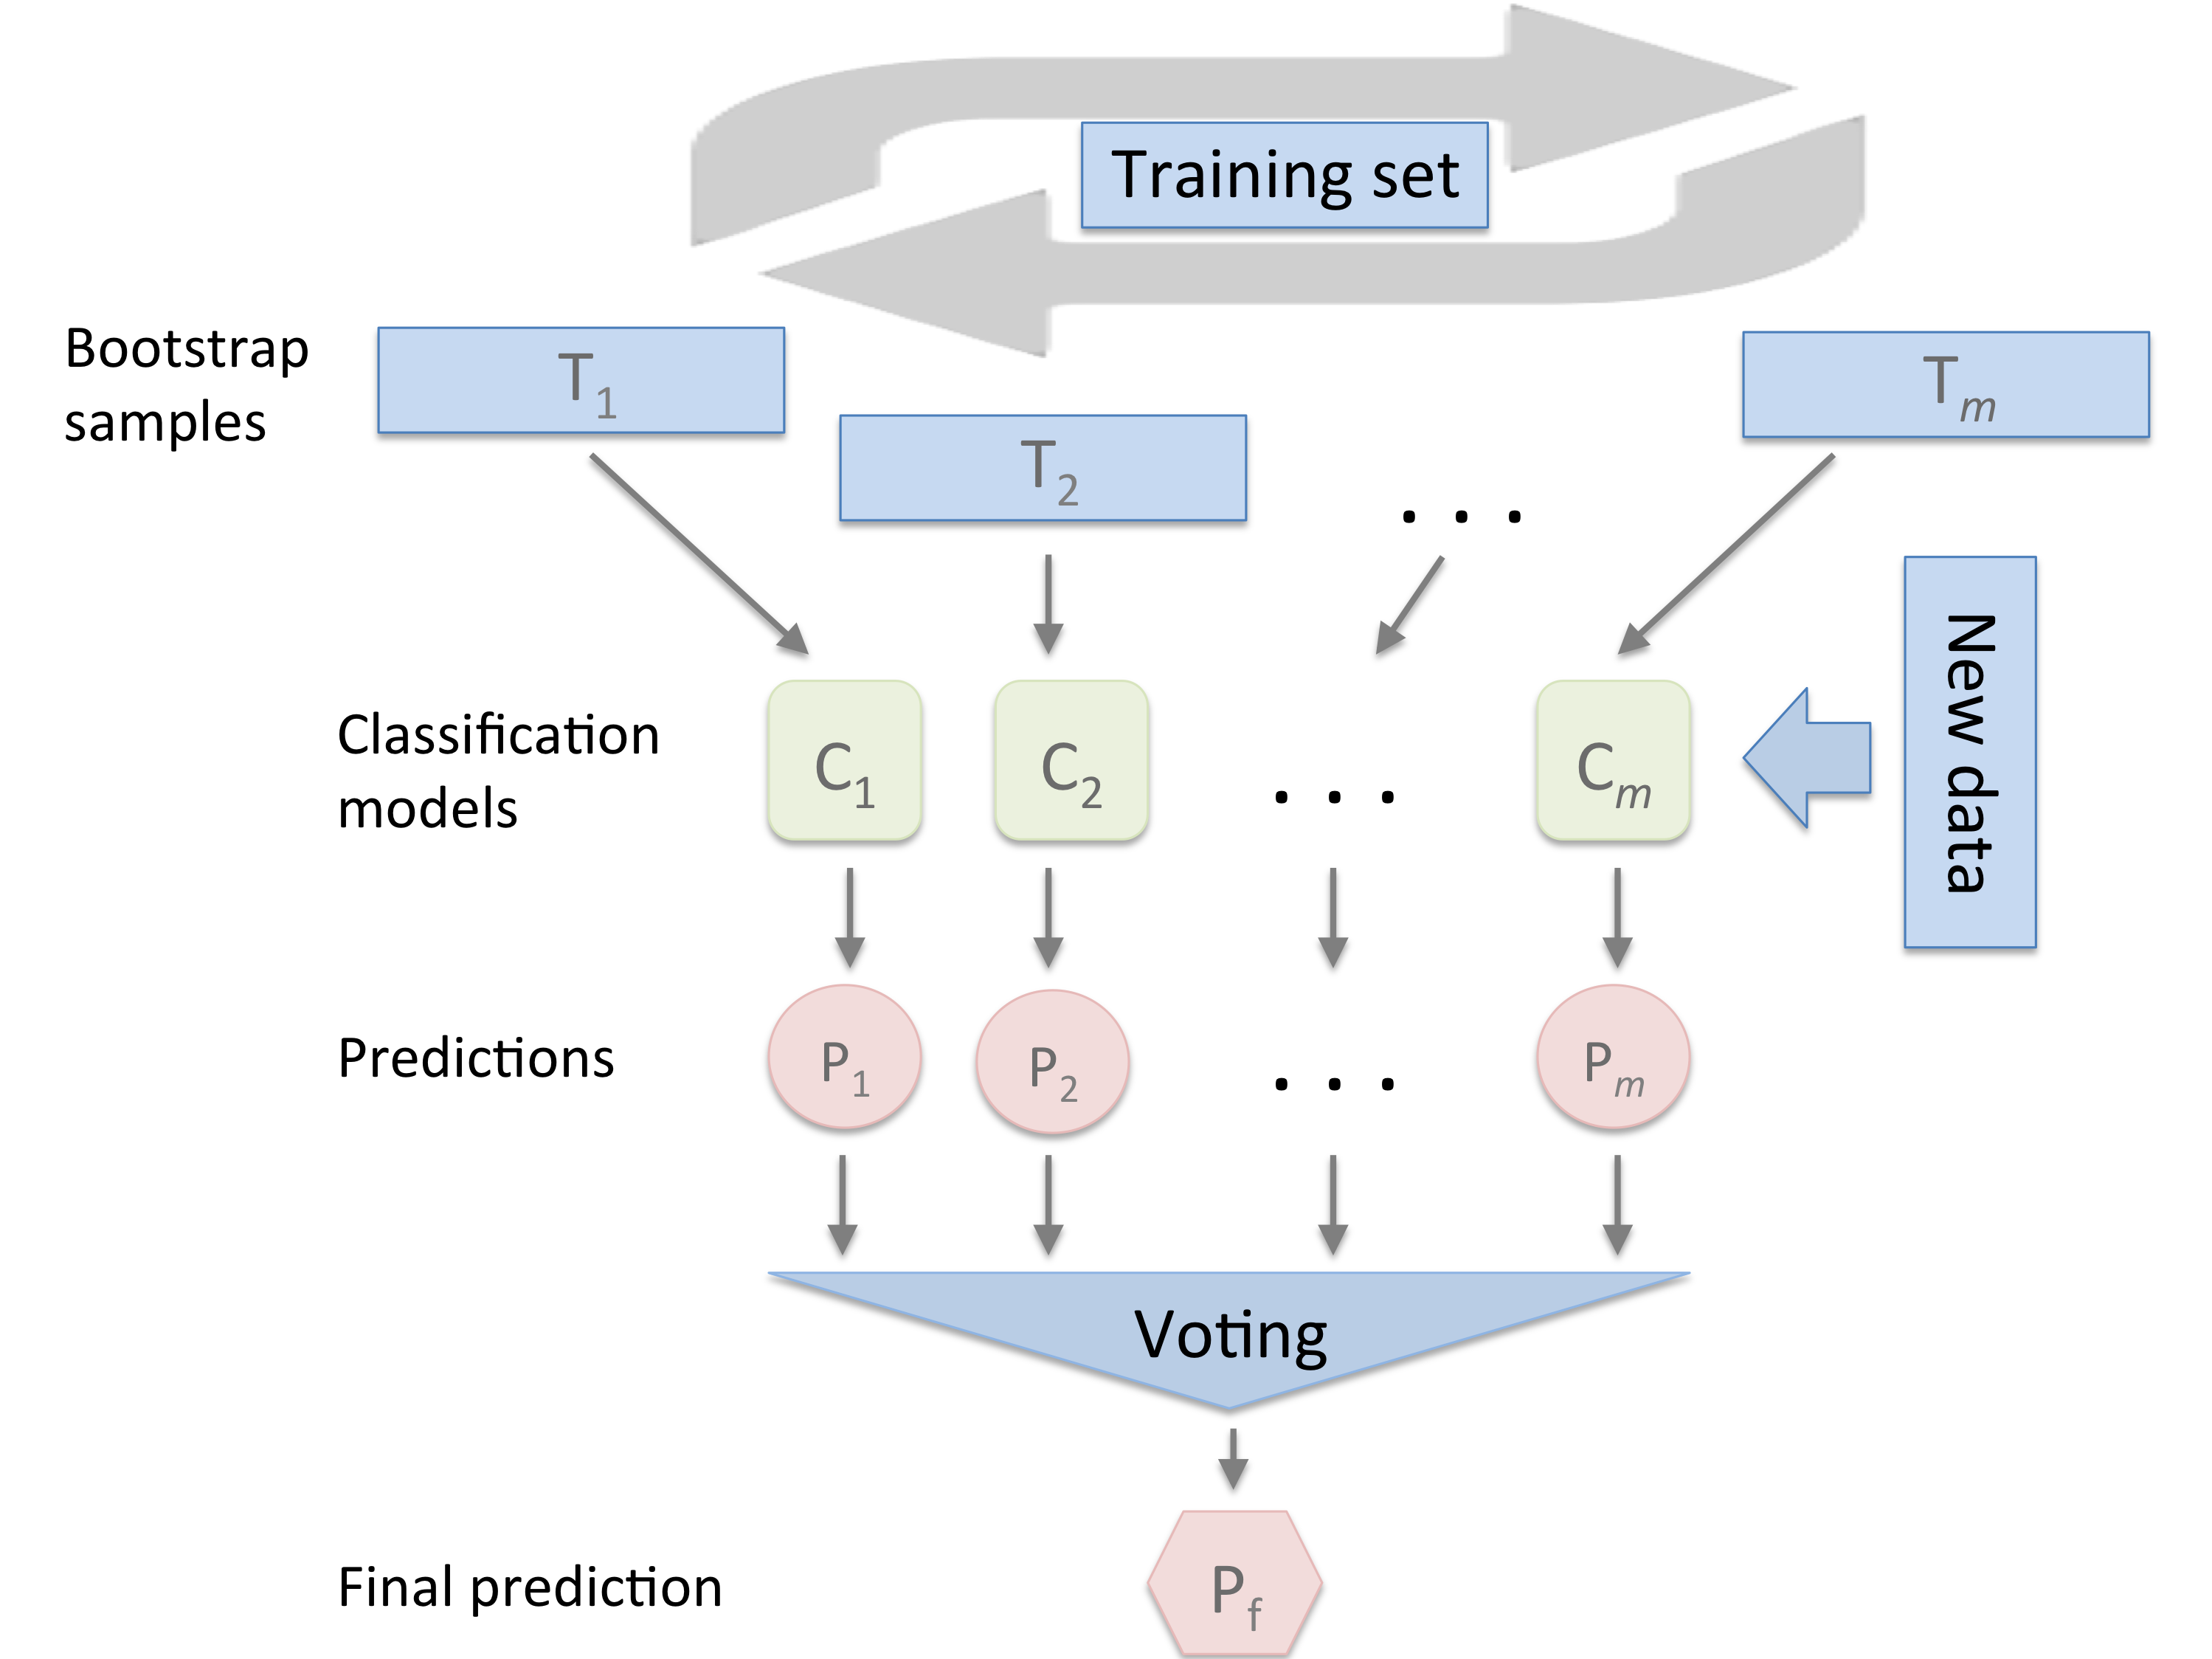

In [23]:
Image(filename='./img/07_06.png', width=500) 

To illustrate the bootstrap procedure, we look at the following table, in which, for example, in the second round, sample $7$ occurs three times for the training of $C_2$, sample $1$ occurs twice and samples $2$ and $3$ occur once each. However, it is usual to use as many *bootstrap samples* per round as there are *training samples*.

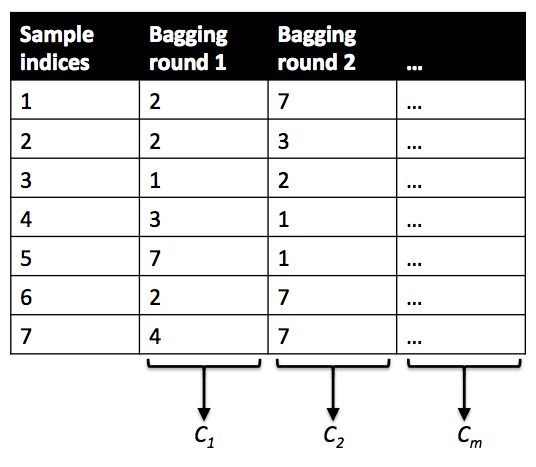

In [24]:
Image(filename='./img/07_07.png', width=400) 

## Special case: Random Forest

Before we see bagging in action, let's take a look at a special ensemble algorithm that also uses bagging to some extent, but has another *random element*, namely the feature selection for the individual decision trees to be trained. This results in the name *random forest* (which we omitted when looking at decision trees and which is already introduced in chapter 3 of [Raschka's book](https://github.com/rasbt/python-machine-learning-book)).

**Algorithm**:
1. Drawing a random bootstrap sample from the training data with size $n$ (with replacement).
2. Generation of a *decision tree* from the *bootstrap sample*. At each node:
    1. **Random selection** of $d$ features (without replacement).
    2. Split the nodes using the feature that provides the best split according to the objective function (e.g. *information gain*).
3. Repeat steps 1 to 2 ($m$ times).
4. Aggregate the predictions of the individual trees to determine the class label by majority voting.

**Notes**
1. The decision trees are usually not very deep. Often only *stumps* are formed (only 1 split).
2. The random feature selection from step 2 distinguishes random forests from a general bagging approach with decision trees.
3. In general, bagging (and thus random forests) lead to
  * Improved accuracy
  * Reduced overfitting

All in all, we have the following *hyperparameters* for random forests that can be tuned:
1. $m$: Number of decision trees
1. $n$: Bootstrap sample size (often chosen to match the number of training data to achieve a good *bias-variance tradeoff*)
1. $d$: Number of features to be considered at the nodes (often chosen as $d=\sqrt k$, where $k$ is the number of features in the samples)
1. $l$: Depth of the trees

## Example: Wine recognition

Let's take a look at bagging using the [Wine-Recognition dataset](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_wine.html) as an example. Fortunately, the dataset is provided directly with `scikit-learn` and only needs to be loaded. In order to be able to plot the decision regions nicely later, we will again limit our analysis to two features (*hue* and *alcohol*).

In [25]:
from sklearn import datasets

wine = datasets.load_wine()

# only use features 'alcohol' (first) and 'hue' (eleventh)
X_in, y_in = wine.data[:,[0,10]], wine.target

# drop class 0 (corresponds to class 1 in the data set we can download directly as in the book ...)
X = X_in[y_in!=0]
y = y_in[y_in!=0]

We then prepare the data as usual by splitting it into training data and test data.

In [26]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

le = LabelEncoder()
y = le.fit_transform(y)

X_train, X_test, y_train, y_test =\
            train_test_split(X, y, 
                             test_size=0.40, 
                             random_state=1)

We now continue with the comparison of bagging, random forest and standard decision trees.

In [27]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

tree = DecisionTreeClassifier(criterion='entropy', 
                              max_depth=None,
                              random_state=1)

bag = BaggingClassifier(estimator=tree, # this is basically a random forest ...
                        n_estimators=500, 
                        max_samples=1.0, 
                        max_features=1.0, # especially if we also use this parameter ...
                        bootstrap=True, 
                        bootstrap_features=False, 
                        n_jobs=2, 
                        random_state=1)

forest = RandomForestClassifier(criterion='entropy', # we also need to say how we want to measure information gain
                                n_estimators=10, 
                                random_state=1,
                                n_jobs=2)

This time we will base our comparison on accuracy (which does not mean that this is necessarily the best value, but is for illustrative purposes only).

In [28]:
from sklearn.metrics import accuracy_score

tree = tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)

tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)
print('Decision tree train/test accuracies %.3f/%.3f'
      % (tree_train, tree_test))

bag = bag.fit(X_train, y_train)
y_train_pred = bag.predict(X_train)
y_test_pred = bag.predict(X_test)

bag_train = accuracy_score(y_train, y_train_pred) 
bag_test = accuracy_score(y_test, y_test_pred) 
print('Bagging train/test accuracies %.3f/%.3f'
      % (bag_train, bag_test))

forest = forest.fit(X_train, y_train)
y_train_pred = forest.predict(X_train)
y_test_pred = forest.predict(X_test)

forest_train = accuracy_score(y_train, y_train_pred) 
forest_test = accuracy_score(y_test, y_test_pred) 
print('Random forest train/test accuracies %.3f/%.3f'
      % (forest_train, forest_test))

Decision tree train/test accuracies 1.000/0.833
Bagging train/test accuracies 1.000/0.896
Random forest train/test accuracies 1.000/0.896


So while all three models achieve an accuracy of 100% on the training data (overfitting?), the bagging algorithms generalize better!

Finally, let's take another look at the decision regions.

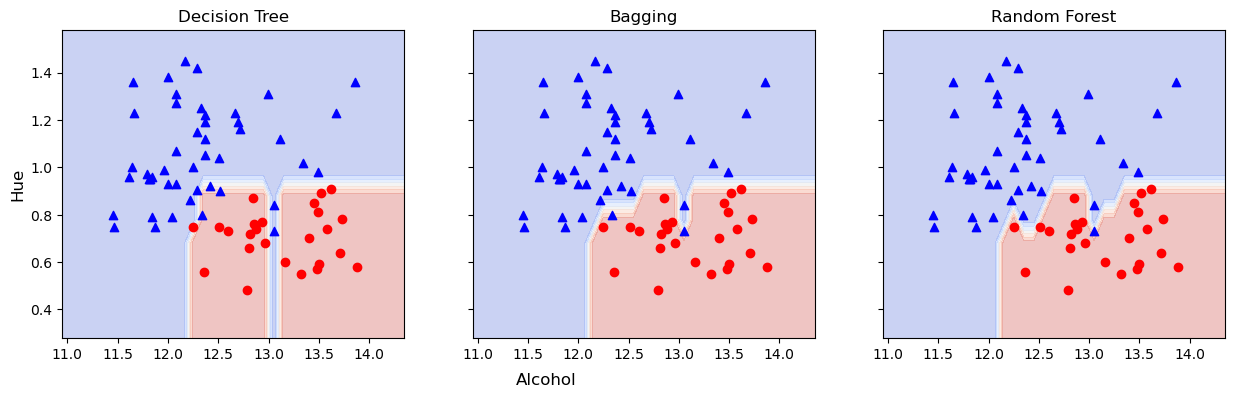

In [29]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

x_min = X_train[:, 0].min() - 0.5
x_max = X_train[:, 0].max() + 0.5
y_min = X_train[:, 1].min() - 0.2
y_max = X_train[:, 1].max() + 0.2

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(nrows=1, ncols=3, 
                        sharex='col', 
                        sharey='row', 
                        figsize=(15, 4))


for idx, clf, tt in zip([0, 1, 2],
                        [tree, bag, forest],
                        ['Decision Tree', 'Bagging', 'Random Forest']):
    clf.fit(X_train, y_train)
    
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    axarr[idx].contourf(xx, yy, Z, cmap="coolwarm", alpha=0.3)
    axarr[idx].scatter(X_train[y_train==0, 0], 
                       X_train[y_train==0, 1], 
                       c='blue', marker='^')
    
    axarr[idx].scatter(X_train[y_train==1, 0], 
                       X_train[y_train==1, 1], 
                       c='red', marker='o')
    
    axarr[idx].set_title(tt)

axarr[0].set_ylabel('Hue', fontsize=12)
plt.text(7.6, 0.1, 
         s='Alcohol', 
         ha='center', va='center', fontsize=12)
    
# plt.tight_layout()
#plt.savefig('./figures/bagging_region.png', 
#            dpi=300, 
#            bbox_inches='tight')
plt.show()

The overfitting of the decision tree classifier is clearly visible in this diagram. Bagging and Random Forest try to capture the two blue points in the middle of the red points, but they would not classify any point below the blue points as blue.

## Summary: Advantages of bagging
1. *Bias*: is addressed by using weak learning methods (*low bias*)
2. *Variance*: is addressed by *random component(s)* of the bagging algorithm

Overall, the performance of these algorithms is often significantly better than that of the individual base classifiers.

# Utilization of weak learning methods through adaptive boosting
---

Original Paper: [The Strength of Weak Learnability (Schapire)](http://rob.schapire.net/papers/strengthofweak.pdf)

One key element of boosting is *weak learning*, which may be only slightly better than random guessing (we've already seen this kind of weak learning in *tree stumps*). The other key idea is to focus on specific training data that is hard to classify.

**Original algorithm**:
1. Drawing a random subset of the training data $d_1$ *without* replacement back from the training data $D$ to train a weak learning procedure $C_1$.
2. Draw a second random subset of the training data $d_2$ without replacement from the training data and add 50% of the previously misclassified samples to train a weak learning procedure $C_2$.
3. Find the subset of training data $d_3$ where $C_1$ and $C_2$ do not match to train a third weak learning procedure $C_3$.
4. Combination of the weak learning methods $C_1,\ C_2$, and $C_3$ by majority vote.

## Adaboost

See the following illustration:

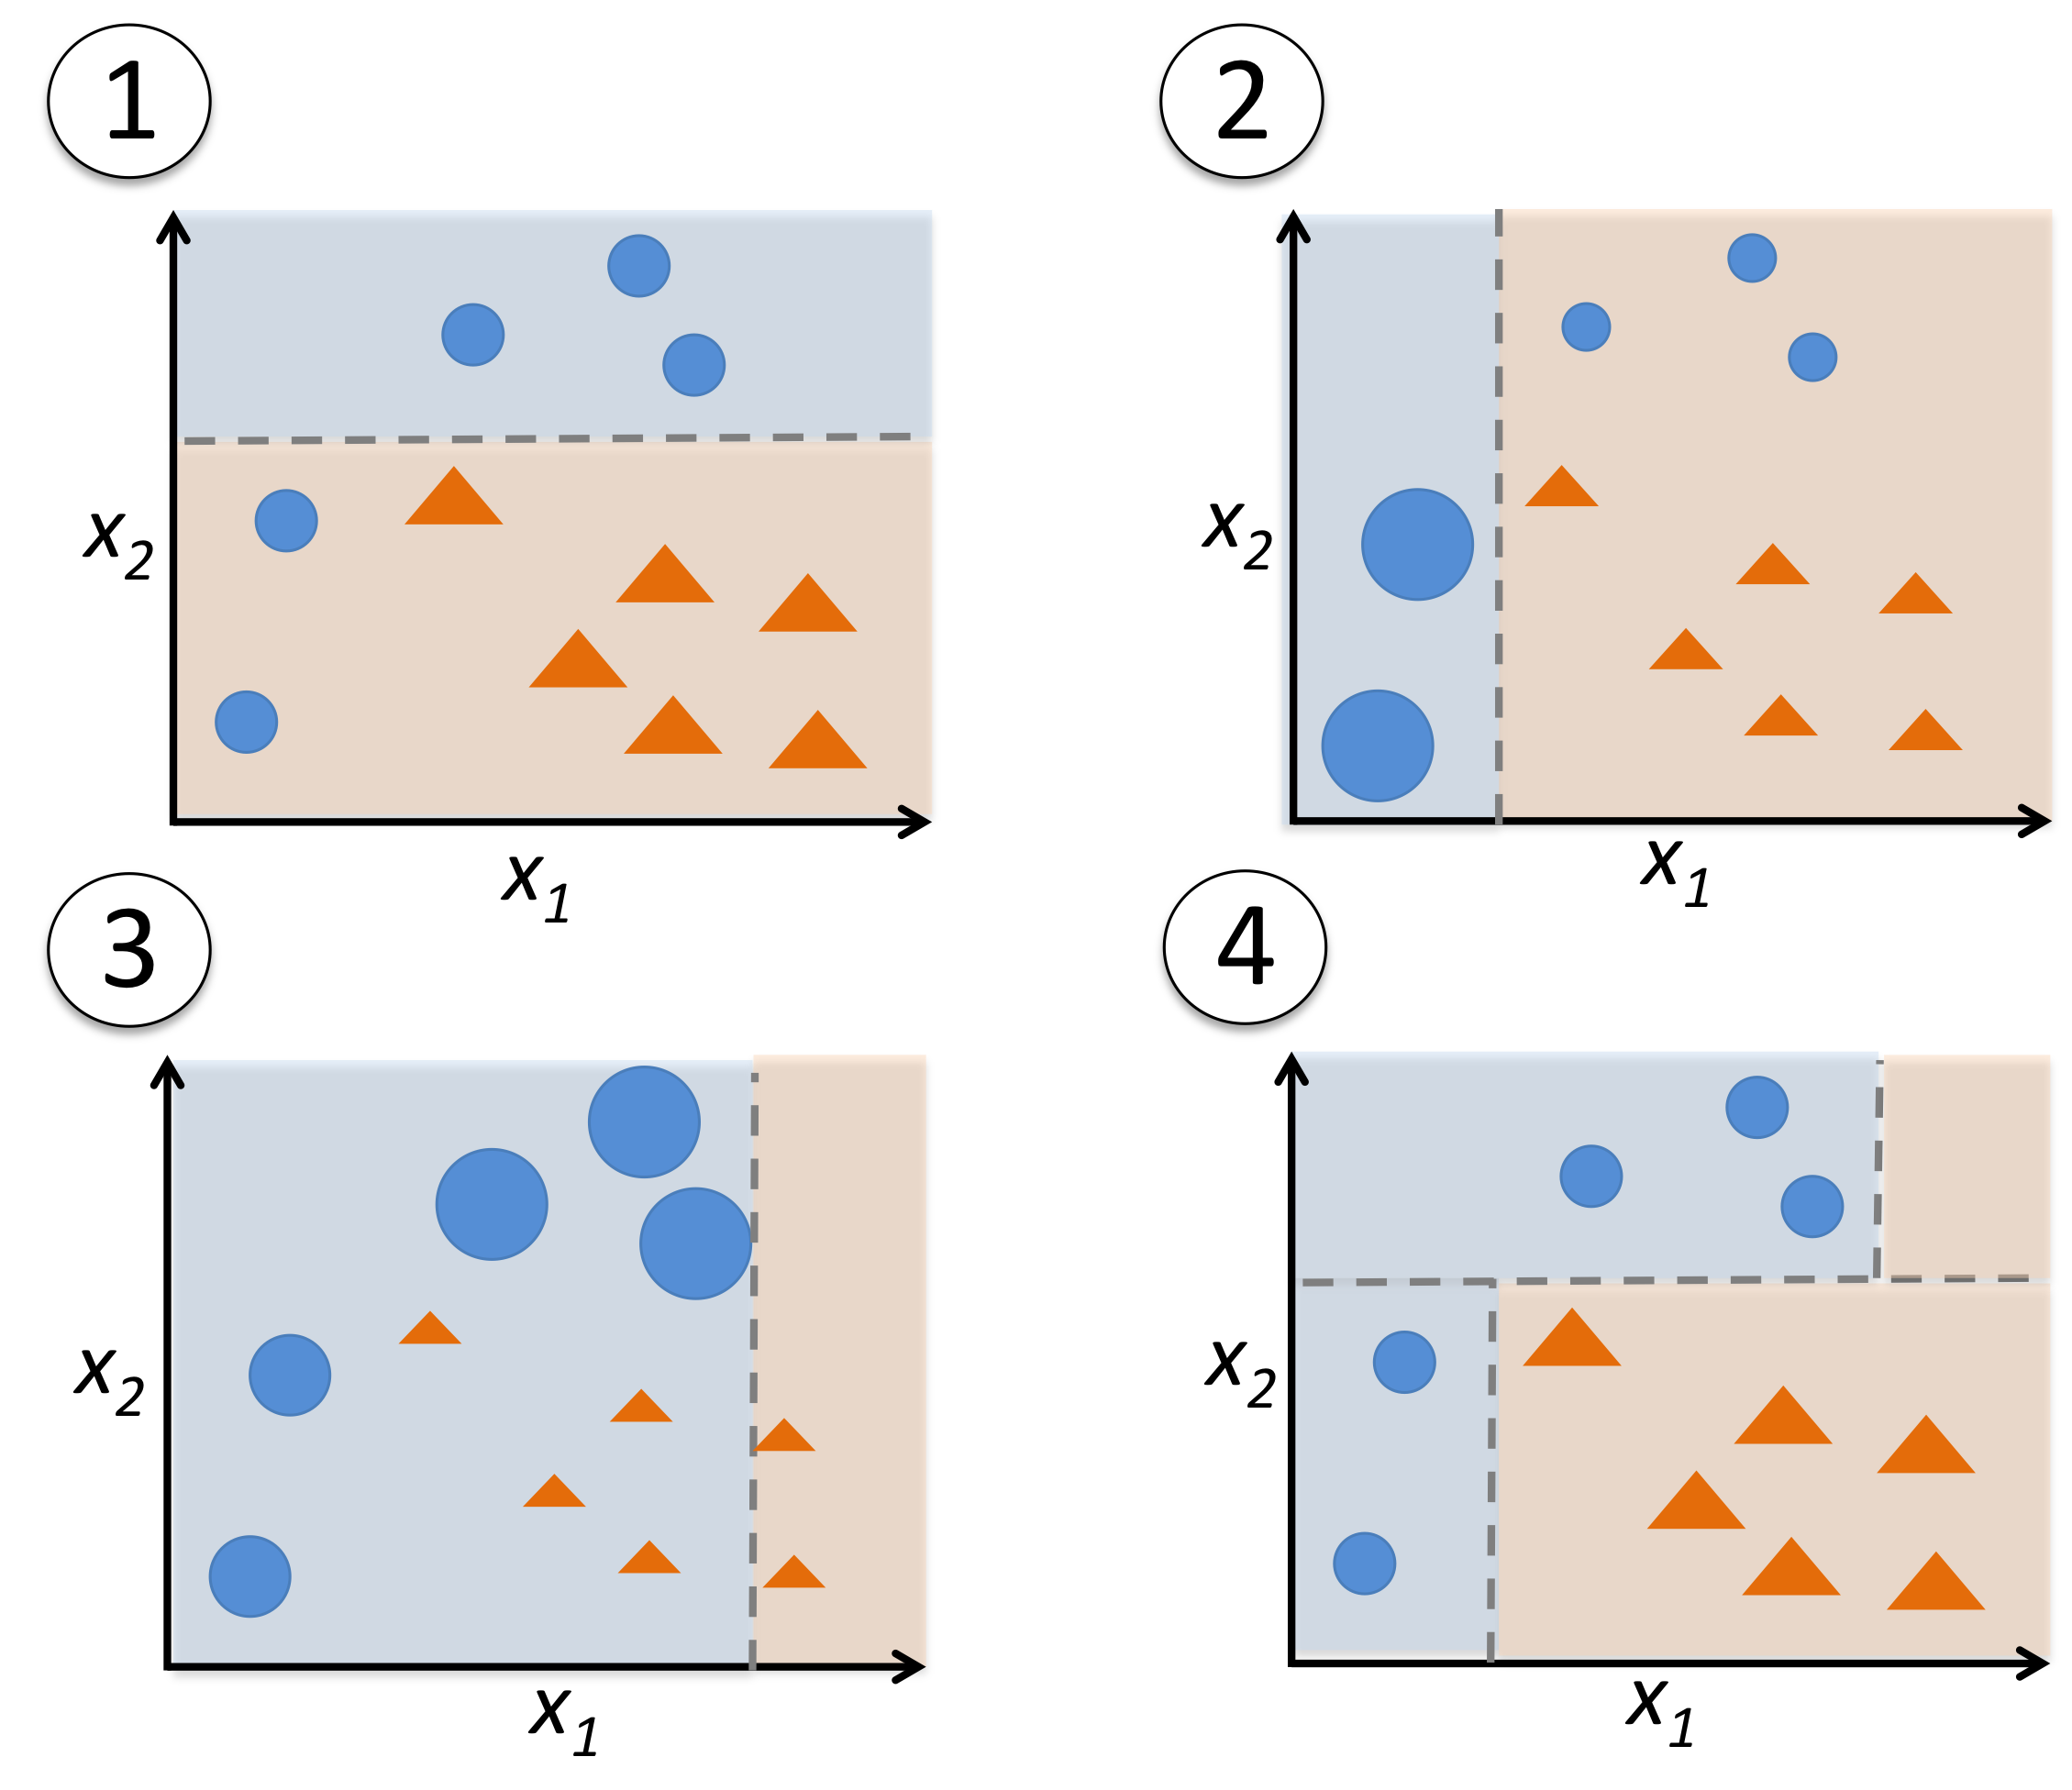

In [30]:
Image(filename='./img/07_09.png', width=400) 

In the figure above:
1. We start with equal weights and can draw a line for the classification (corresponding to a decision tree stump).
2. We misclassified the two blue samples below the dashed line in the first step, so they get more weight in the next step.
3. Now the samples above have been misclassified, so they get a higher weight in the next step, which leads to the third step.
4. Assuming we only do three rounds, the final prediction is done using majority voting.

**Adaboost algorithm** (simplified for binary classification):

Let  
$\mathbf{X}:=\left\{\mathbf{x}_i\mid i=1,\dots,n\right\}$  
be the set of training data and let  
$\mathbf{y}=(y_1,\dots,y_n)^T$  
be the vector of *assigned class labels*, where $y_i\in\{1,-1\}\>,\ i=1,\dots,n$.
1. Initialize a *weight vector* $\mathbf{w}=(\frac 1n,\dots,\frac 1n)^T$, i.e. $w_i = \frac 1n\>,\ i=1,\dots,n$  
for each sample (**note**: *AdaBoost* does not draw a random sample, but always uses all samples)
2. In the $j$ th of the $m$ *boosting rounds*:
    1. Train a weak learning procedure $C_j(\mathbf{X},\mathbf{y},\mathbf{w})$ that leads to a *predictor* $f_j$
    2. Predict the class labels of the training data: $\mathbf{\hat y}_j=f_j(\mathbf{X})$
    2. Compare the predicted class labels with the ground truth, resulting in an *indicator vector* $\mathbf{\bar\chi}_j:=\neg{(\mathbf{\hat y}_j\equiv\mathbf{y})}$ (which means that $\mathbf{\chi}_j = 1$ if the prediction is **in**correct and $0$ otherwise).
    3. Calculate the *weighted error rate* as: $\varepsilon_j = \mathbf{w}\cdot\mathbf{\bar\chi}_j$ and coefficient $\alpha_j:=\frac12\ln\left(\frac{1-\varepsilon_j}{\varepsilon_j}\right)$
    4. Update weights: $w_i^{\text{pre}} := w_i\cdot e^{-\alpha_j\cdot\hat y_{j,i}\cdot y_i}$ and $w_i^{\text{new}}:= \frac{w_i^{\text{pre}}}{\sum_{i=1}^n w_i^{\text{pre}}}$ (so that the sum of the weights is always $1$).
3. The final Adaboost classifier $C_{\text{ab}}$ uses the predictor
$$
  f_{\text{ab}}(\mathbf{x})=\text{sign}\left(\sum_{j=1}^m\alpha_j\cdot f_j(\mathbf{x})\right)
$$
  for each data set $\mathbf{x}$.

To further illustrate what happens in AdaBoost, consider the following table, which shows the initial situation for an assumed classification problem with 10 samples, resulting in initial weights of 0.1. Updating the weights then ensures that the correctly classified samples receive a lower weight, while the incorrectly classified ones receive a higher weight in the next step.

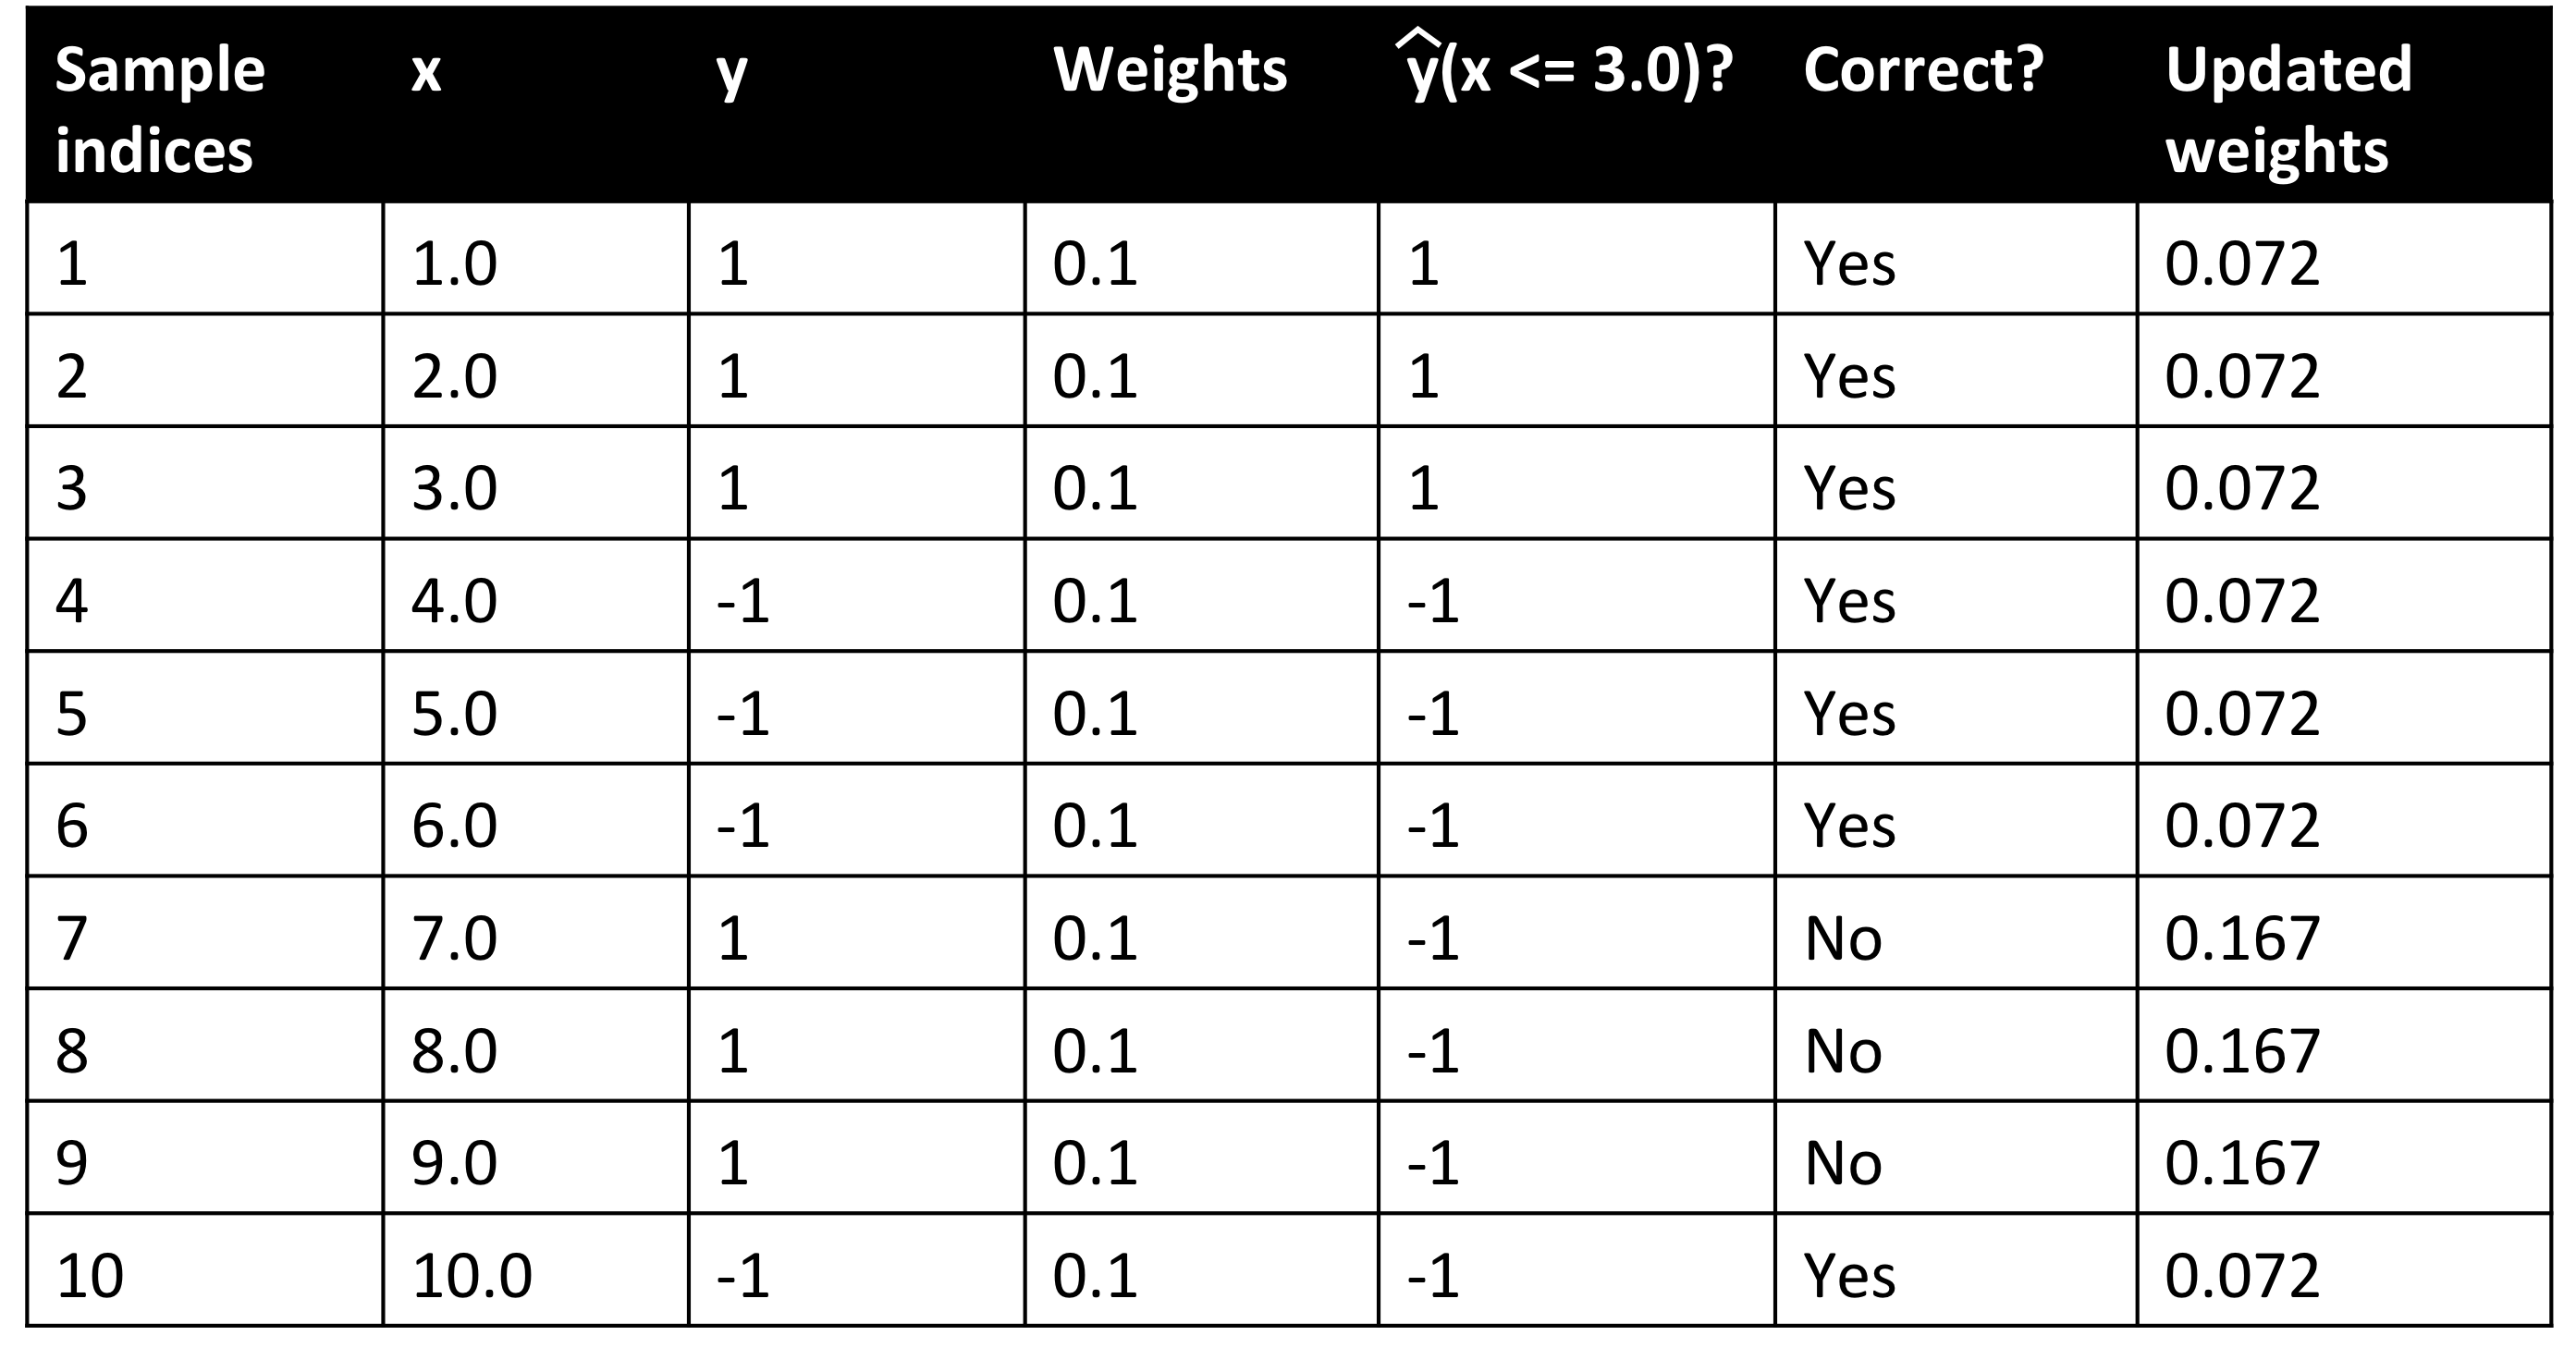

In [31]:
Image(filename='./img/07_10.png', width=500) 

We check the numbers with code:

In [32]:
import numpy as np
from math import log
# weights
w = np.empty(10)
w.fill(.1)
# labels (ground truth)
y = np.empty(10)
y.fill(1)
y[3] = -1
y[4] = -1
y[5] = -1
y[9] = -1
# predicted labels
yhat = y.copy()
yhat[6] = -1
yhat[7] = -1
yhat[8] = -1
# indicator vector
chi = np.where(y-yhat == 0, 0, 1)
# weighted error rate
eps = np.dot(w,chi)
# update coefficient
alpha = log((1-eps)/eps)/2
# unnormalized weights
wpre = w*np.exp(-alpha*y*yhat)
# normalized weights
wnew = np.round(wpre/np.sum(wpre),3)
wnew

array([0.071, 0.071, 0.071, 0.071, 0.071, 0.071, 0.167, 0.167, 0.167,
       0.071])

The updated coefficients in the table are therefore more or less correct (only incorrectly rounded).

Now let's take a look at the AdaBoost classifier in action.

In [33]:
from sklearn.ensemble import AdaBoostClassifier

tree = DecisionTreeClassifier(criterion='entropy', 
                              max_depth=1,  # this is a stump only
                              random_state=0)

ada = AdaBoostClassifier(estimator=tree,
                         n_estimators=500, 
                         learning_rate=0.1,
                         random_state=0)

First, let's check how AdaBoost compares to a simple tree stump.

In [34]:
tree = tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)

tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)
print('Decision tree train/test accuracies %.3f/%.3f'
      % (tree_train, tree_test))

ada = ada.fit(X_train, y_train)
y_train_pred = ada.predict(X_train)
y_test_pred = ada.predict(X_test)

ada_train = accuracy_score(y_train, y_train_pred) 
ada_test = accuracy_score(y_test, y_test_pred) 
print('AdaBoost train/test accuracies %.3f/%.3f'
      % (ada_train, ada_test))

Decision tree train/test accuracies 0.845/0.854
AdaBoost train/test accuracies 1.000/0.875


In fact, AdaBoost seems to overfit significantly for this particular problem. In fact, its performance on the test data is only slightly better than that of the decision tree stump, while it performs perfectly on the training data. So let's look at the decision regions again.

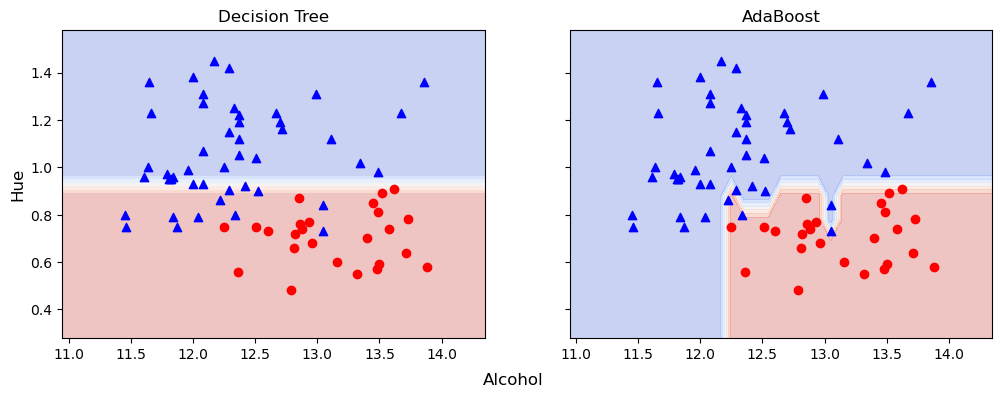

In [35]:
x_min, x_max = X_train[:, 0].min() - 0.5, X_train[:, 0].max() + 0.5
y_min, y_max = X_train[:, 1].min() - 0.2, X_train[:, 1].max() + 0.2
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(1, 2, sharex='col', sharey='row', figsize=(12, 4))


for idx, clf, tt in zip([0, 1],
                        [tree, ada],
                        ['Decision Tree', 'AdaBoost']):
    clf.fit(X_train, y_train)
    
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    axarr[idx].contourf(xx, yy, Z, cmap='coolwarm', alpha=0.3)
    axarr[idx].scatter(X_train[y_train==0, 0], 
                       X_train[y_train==0, 1], 
                       c='blue', marker='^')
    axarr[idx].scatter(X_train[y_train==1, 0], 
                       X_train[y_train==1, 1], 
                       c='red', marker='o')
    axarr[idx].set_title(tt)

axarr[0].set_ylabel('Hue', fontsize=12)
plt.text(10.5, 0.1, 
         s='Alcohol', 
         ha='center', va='center', fontsize=12)
    
# plt.tight_layout()
#plt.savefig('./figures/adaboost_region.png', 
#           dpi=300, 
#           bbox_inches='tight')
plt.show()

The decision domain for AdaBoost does not look too different from the bagging algorithms we have seen before. However, these generalize a little better, at least for the problem at hand.

## Learning outcomes
---

The most important learning objectives of this notebook at a glance:

* Ensembles can use different voting strategies to make a prediction
* The error of an ensemble is significantly lower than that of the individual base classifiers, as long as they are better than random
* Combining many weak learners with bagging and/or boosting strategies can make very powerful predictive models
* Training ensembles is computationally more intensive

In conclusion, using ensembles can improve ML models significantly and can even be worth real money: Paper at [\$1 million Netflix price](https://www.asc.ohio-state.edu/statistics/dmsl//GrandPrize2009_BPC_BigChaos.pdf). On the other hand, this may not be very practical...